# Quantum Tomography analysis

This is the analysis code to measure the polarisation of a vector meson using Quantum Tomography.

In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import pickle
import uproot
import numpy as np
import pandas as pd
# import xgboost as xgb
import sklearn

sys.path.insert(0, '../')
# import analysis_utils as au

# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## A few infos on the libraries

### uproot

uproot is a Python package that provides tools for reading/writing ROOT files using Python and Numpy (does not depend on ROOT) and is primarly intended to stream data into machine learning libraries in Python.

We use uproot for reading and converting ROOT Trees into ***pandas*** **DataFrame**.
For more details: https://github.com/scikit-hep/uproot.

Now we load our data using uproot: signal and background for the training of the models and the unknown data on which we would like to have the model predictions

In [ ]:
# datatree = uproot.open('AnalysisResults.root')['Data']
# datatree = uproot.open('MC/AnalysisResultsCohJpsi_GridTest.root')['MyTask/fOutputTreeMC']
datatree = uproot.open('MC/AnalysisResultsCohJpsiLocal.root')['MyTask/fOutputTreeMC']

In [ ]:
datatree.keys()
# IncohMC_std_gener.keys()
# background_treeMine.keys()
# data_treeMine.keys()

In [ ]:
data_df = datatree.pandas.df()

In [ ]:
len(data_df.index)

In [ ]:
generatedevents = len(data_df.index)
generatedevents

## Four-momentum logic

In [4]:
import skhep
from skhep import math


# Levi-Civita symbol
import sympy
from sympy import LeviCivita

Quantum tomography works by defining three coordinate axes in a Lorentz-invariant approach.

Using \\( k_+^\mu \\), \\(k_-^\mu \\) for the positive and the negative muon, respectively, we construct the vector meson 4-vector \\( Q^\mu \\) as:

\\[ Q^\mu = k_+^\mu + k_-^\mu \\]

If \\( p_A^\mu, p_B^\mu \\) are the two beams, the three axes \\( X^\mu, Y^\mu, Z^\mu \\) are defined as:

\\[ Z^\mu = p_A^\mu  Q{\cdot}p_B - p_B^\mu Q{\cdot}p_A \\]

\\[ Y^\mu = \epsilon^{\mu\nu\alpha\beta}p_{A \nu}p_{B \alpha}Q_\beta \\]

\\[ X^\mu = Q^\mu - p_A^\mu \frac{Q^2}{2Q{\cdot}p_A} - p_B^\mu \frac{Q^2}{2Q{\cdot}p_B} \\]





In [5]:
def CosThetaTrueCollinsSoper( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "X  = ", x )
#     print( "Y  = ", y )
#     print( "Z  = ", z )
#     print( "Xh = ", xhat )
#     print( "Yh = ", yhat )
#     print( "Zh = ", zhat )
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
    NormOfdiff = math.sqrt(-diff.dot(diff))
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [6]:
help(math.atan2)

Help on built-in function atan2 in module math:

atan2(y, x, /)
    Return the arc tangent (measured in radians) of y/x.
    
    Unlike atan(y/x), the signs of both x and y are considered.



In [7]:
def PhiTrueCollinsSoper( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
#     pA            = math.LorentzVector( 0, 0,-1, 1 )
#     pB            = math.LorentzVector( 0, 0, 1, 1 )
    pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
    pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
    NormOfdiff = math.sqrt(-diff.dot(diff))
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );
    PhiCS            = math.atan2( SinThetaSinPhiCS, SinThetaCosPhiCS );


    return PhiCS

    

#### Small test procedure
Here we are testing the few functions using our data.

In [ ]:
data_df.iloc[4]

In [ ]:
CosThetaTest = CosThetaTrueCollinsSoper( 1.201056, 0.586901, 21.715403, 21.756766, -1.260339, -0.528812, -9.929302, 10.023487 )

In [ ]:
CosThetaTest

In [ ]:
LeviCivita(0,1,3,2)

### Speed check

In [ ]:
data_df.loc[4:5]

In [ ]:
# singleline_df = data_df.loc[4:5]
# singleline_df

singleline = [ [1.348618, 0.352406, -48.828766, 48.848774, -1.334760, -0.386442, -19.233398, 19.283819, 0.036749, -3.783632, 3.096845],
               [0.610672, 1.115761,  -5.101897,  5.259121, -0.646307, -1.072639, -18.913221, 18.954929, 0.055941, -2.745375, 3.096976]]

singleline_df = pd.DataFrame(singleline, columns = ['fMCTrkPx1', 'fMCTrkPy1', 'fMCTrkPz1','fMCTrkE1','fMCTrkPx2', 'fMCTrkPy2', 'fMCTrkPz2','fMCTrkE2', 'fMCTrkTrkPt', 'fMCTrkTrkY', 'fMCTrkTrkM']) 
singleline_df


In [ ]:
%%timeit 

singleline_df['CosTheta'] = singleline_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fMCTrkPx1'], x['fMCTrkPy1'], x['fMCTrkPz1'], x['fMCTrkE1'], x['fMCTrkPx2'], x['fMCTrkPy2'], x['fMCTrkPz2'],  x['fMCTrkE2']   ), axis=1)
singleline_df

In [ ]:
singleline_df

In [ ]:
def CosThetaTrueCollinsSoperV2( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "X  = ", x )
#     print( "Y  = ", y )
#     print( "Z  = ", z )
#     print( "Xh = ", xhat )
#     print( "Yh = ", yhat )
#     print( "Zh = ", zhat )
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
#     NormOfdiff = math.sqrt(-diff.dot(diff))
    NormOfdiff = (-diff.dot(diff))**0.5
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [ ]:
def CosThetaTrueCollinsSoperVector( row ):
    
    px1 = row['fMCTrkPx1']
    py1 = row['fMCTrkPy1']
    pz1 = row['fMCTrkPz1']
    E1  = row['fMCTrkE1']
    px2 = row['fMCTrkPx2']
    py2 = row['fMCTrkPy2']
    pz2 = row['fMCTrkPz2']
    E2  = row['fMCTrkE2']
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "X  = ", x )
#     print( "Y  = ", y )
#     print( "Z  = ", z )
#     print( "Xh = ", xhat )
#     print( "Yh = ", yhat )
#     print( "Zh = ", zhat )
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
    difference = diff.dot(diff)
#     difference -= diff.dot(diff)*2
#     if diff.dot(diff) > 0.:
#     NormOfdiff = math.sqrt(-difference)
    NormOfdiff = (-difference)**0.5
#         NormOfdiff = math.sqrt(-diff.dot(diff))
#     else:
#         NormOfdiff = 0.
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [ ]:
# %timeit singleline_df['CosThetaV'] = np.vectorize(CosThetaTrueCollinsSoperV2)( singleline_df['fMCTrkPx1'].values, singleline_df['fMCTrkPy1'].values,  singleline_df['fMCTrkPz1'].values, singleline_df['fMCTrkE1'].values, singleline_df['fMCTrkPx2'].values, singleline_df['fMCTrkPy2'].values, singleline_df['fMCTrkPz2'].values,  singleline_df['fMCTrkE2'].values  )

# %timeit 

%timeit singleline_df['CosThetaV'] = singleline_df.apply(CosThetaTrueCollinsSoperVector, axis=1)
# singleline_df

## Adding the two columns to the dataframe

Now we are adding two new columns to the dataframe:
\\( \cos\theta \\) and \\( \phi \\).

In [ ]:
def CosThetaTrueCollinsSoperOne( px1 ):
    return px1
def CosThetaTrueCollinsSoperTwo( px1, py1 ):
    return px1+px1
def CosThetaTrueCollinsSoperThree( px1, py1, pz1 ):
    return px1+py1+pz1
def CosThetaTrueCollinsSoperFour( px1, py1, pz1, E1 ):
        return px1+py1+pz1+E1

# def CosThetaTrueCollinsSoperOne( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
# def CosThetaTrueCollinsSoperOne( px1, py1, pz1, E1, px2, py2, pz2, E2 ):


In [ ]:
# data_df['CosTheta'] = data_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0'], x['fEnergySingleMuon_0'], x['fPxSingleMuon_1'], x['fPySingleMuon_1'], x['fPzSingleMuon_1'],  x['fEnergySingleMuon_1']   ), axis=1)
# data_df['Phi']      = data_df.apply(lambda x: PhiTrueCollinsSoper(     x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0'], x['fEnergySingleMuon_0'], x['fPxSingleMuon_1'], x['fPySingleMuon_1'], x['fPzSingleMuon_1'],  x['fEnergySingleMuon_1']   ), axis=1)
data_df['CosTheta'] = data_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fMCTrkPx1'], x['fMCTrkPy1'], x['fMCTrkPz1'], x['fMCTrkE1'], x['fMCTrkPx2'], x['fMCTrkPy2'], x['fMCTrkPz2'],  x['fMCTrkE2']   ), axis=1)
data_df['Phi']      = data_df.apply(lambda x: PhiTrueCollinsSoper(     x['fMCTrkPx1'], x['fMCTrkPy1'], x['fMCTrkPz1'], x['fMCTrkE1'], x['fMCTrkPx2'], x['fMCTrkPy2'], x['fMCTrkPz2'],  x['fMCTrkE2']   ), axis=1)


In [ ]:
data_df

In [ ]:
data_df['CosTheta'].plot.hist(bins=100, alpha=0.6)


In [ ]:
data_df['Phi'].plot.hist(bins=100, alpha=0.6)


## Probe matrix
The probe matrix \\(\rho(l)\\) is defined as follows:
\\[\rho(l) = \frac{1+a}{3}\cdot \delta_{ij} - a{\cdot}l_i\cdot l_j - ib\cdot \epsilon_{ijk}\cdot l_k,\\]
where \\(a = 0.5\\) and \\(b = c_A{\cdot}c_V = \sin^2\theta_W \simeq 0.22\\).

In [8]:
def ProbeMatrix( CosTheta, Phi, returnValue ):
    rho      = np.array([[-999.j, -999.j, -999.j], [-999.j, -999.j, -999.j], [-999.j, -999.j, -999.j]])
    SinTheta = math.sqrt(1 - CosTheta*CosTheta)
    CosPhi   = math.cos(Phi)
    SinPhi   = math.sin(Phi)
    l = [ SinTheta*CosPhi, SinTheta*SinPhi, CosTheta ]
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                epsilon = LeviCivita(i,j,k)
                delta = -999.
                if i == j:
                    delta = 0.5
                else:
                    delta = 0.
                rho[i][j] = delta - 0.5*l[i]*l[j]- (1j)*0.22*epsilon*l[k]
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]

    

In [19]:
%timeit Probe = ProbeMatrix( -0.419608,  -2.426581, 0 )
Probe

4.43 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


array([[ 0.26511665+0.j        , -0.20394467+0.09231376j,
        -0.14379867+0.j        ],
       [-0.20394467-0.09231376j,  0.32291879+0.j        ,
        -0.12485761+0.j        ],
       [-0.14379867+0.j        , -0.12485761+0.j        ,
         0.41196456+0.j        ]])

In [ ]:
for j in range(0,3):
    print(1j)

### Saving the dataframe to file for later

In [ ]:
data_df.to_pickle("DataframeCohJpsiTransverse.txt")

In [10]:
data_df = pd.read_pickle("DataframeCohJpsiTransverse.txt")
data_df

,fMCTrkPx1,fMCTrkPy1,fMCTrkPz1,fMCTrkE1,fMCTrkPx2,fMCTrkPy2,fMCTrkPz2,fMCTrkE2,fMCTrkTrkPt,fMCTrkTrkY,fMCTrkTrkM,CosTheta,Phi
entry,,,,,,,,,,,,,
0,1.299513,0.260663,-8.448884,8.552864,-1.254716,-0.212718,-27.344528,27.374331,0.065617,-3.142161,3.096873,0.541562,2.505073
1,1.319006,0.767814,-25.895584,25.940737,-1.248877,-0.815178,-39.270367,39.298817,0.084626,-3.739864,3.096931,0.216549,-1.994555
2,0.611135,-0.836853,-28.619997,28.638947,-0.600263,0.845063,-4.219054,4.345806,0.013624,-3.056592,3.096831,-0.741565,1.552080
3,-0.556335,-0.147648,-42.622665,42.626682,0.556427,0.118344,-1.550662,1.655093,0.029304,-3.351989,3.097086,-0.928921,1.809505
4,1.348618,0.352406,-48.828766,48.848774,-1.334760,-0.386442,-19.233398,19.283819,0.036749,-3.783632,3.096845,-0.434152,-1.691455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,0.334731,1.507037,-15.818774,15.894276,-0.371028,-1.457784,-21.508055,21.560854,0.061183,-3.183983,3.096890,0.164816,2.272580
65996,-0.314330,-1.408587,-8.215141,8.341620,0.264504,1.427113,-17.230337,17.291683,0.053159,-2.802807,3.096941,0.350114,-1.416001
65997,-0.592038,1.384652,-45.662212,45.687160,0.596147,-1.388847,-29.597004,29.635757,0.005873,-3.884036,3.097115,-0.215506,-0.374059


### 3D maps

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


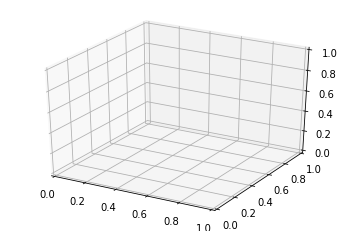

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.set_aspect("equal")


In [ ]:
# draw sphere
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="r")


In [ ]:
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)


In [3]:
def ApplyCos(x):
    return np.cos(x)

def ApplySin(x):
    return np.sin(x)

def ApplyCosToSin(x):
    return np.sqrt(1-x*x)

def ApplyInverseCos(x):
    return np.arccos(x)

def ApplyInverseSin(x):
    return np.arcsin(x)

def ApplyInverseTan(y,x):
    return math.atan2(y,x)


In [4]:
CosThetaColumn = data_df.loc[:,'CosTheta']
PhiColumn      = data_df.loc[:,'Phi']
data_df['Theta'] = data_df.apply(lambda x: ApplyInverseCos(x['CosTheta']  ), axis=1)
data_df


,fMCTrkPx1,fMCTrkPy1,fMCTrkPz1,fMCTrkE1,fMCTrkPx2,fMCTrkPy2,fMCTrkPz2,fMCTrkE2,fMCTrkTrkPt,fMCTrkTrkY,fMCTrkTrkM,CosTheta,Phi,Theta
entry,,,,,,,,,,,,,,
0,1.299513,0.260663,-8.448884,8.552864,-1.254716,-0.212718,-27.344528,27.374331,0.065617,-3.142161,3.096873,0.541562,2.505073,0.998502
1,1.319006,0.767814,-25.895584,25.940737,-1.248877,-0.815178,-39.270367,39.298817,0.084626,-3.739864,3.096931,0.216549,-1.994555,1.352518
2,0.611135,-0.836853,-28.619997,28.638947,-0.600263,0.845063,-4.219054,4.345806,0.013624,-3.056592,3.096831,-0.741565,1.552080,2.406196
3,-0.556335,-0.147648,-42.622665,42.626682,0.556427,0.118344,-1.550662,1.655093,0.029304,-3.351989,3.097086,-0.928921,1.809505,2.762286
4,1.348618,0.352406,-48.828766,48.848774,-1.334760,-0.386442,-19.233398,19.283819,0.036749,-3.783632,3.096845,-0.434152,-1.691455,2.019893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,0.334731,1.507037,-15.818774,15.894276,-0.371028,-1.457784,-21.508055,21.560854,0.061183,-3.183983,3.096890,0.164816,2.272580,1.405224
65996,-0.314330,-1.408587,-8.215141,8.341620,0.264504,1.427113,-17.230337,17.291683,0.053159,-2.802807,3.096941,0.350114,-1.416001,1.213104
65997,-0.592038,1.384652,-45.662212,45.687160,0.596147,-1.388847,-29.597004,29.635757,0.005873,-3.884036,3.097115,-0.215506,-0.374059,1.788006


In [6]:
CosPhiColumn   = np.vectorize(ApplyCos)(PhiColumn)
SinPhiColumn   = np.vectorize(ApplySin)(PhiColumn)
SinThetaColumn = np.vectorize(ApplyCosToSin)(CosThetaColumn)

In [8]:
xArray = SinThetaColumn*CosPhiColumn
yArray = SinThetaColumn*SinPhiColumn
zArray = CosThetaColumn

In [10]:
# ax.plot_wireframe(xArray, yArray, zArray, color="r")

In [11]:
# from mayavi import mlab


In [12]:
# from mayavi import mlab
# # import numpy as np

# # Create a sphere
# r = 1.0
# pi = np.pi
# cos = np.cos
# sin = np.sin
# phi, theta = np.mgrid[0:pi:101j, 0:2 * pi:101j]

# x1 = r*sin(phi)*cos(theta)
# y1 = r*sin(phi)*sin(theta)
# z1 = r*cos(phi)

# mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
# mlab.clf()

# # data = np.genfromtxt('leb.txt')
# # xx, yy, zz = np.hsplit(data, 3)


# mlab.mesh(x1 , y1 , z1, color=(0.0,0.5,0.5))
# mlab.points3d(xArray, yArray, zArray, scale_factor=0.05)


# mlab.show()


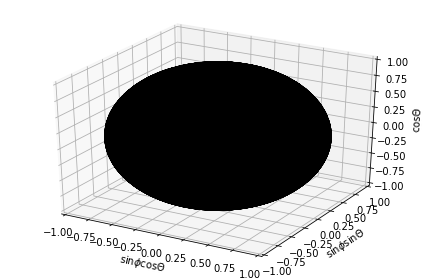

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Import data
# data = np.genfromtxt('leb.txt')
# theta, phi, r = np.hsplit(data, 3) 
# theta = theta * pi / 180.0
# phi = phi * pi / 180.0
# xx = sin(phi)*cos(theta)
# yy = sin(phi)*sin(theta)
# zz = cos(phi)


#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

# ax.scatter(xx,yy,zz,color="k",s=20)
ax.scatter(xArray,yArray,zArray,color="k",s=20)
# ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
# ax.plot_surface( xArray,yArray,zArray, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
# ax.set_aspect("equal")
# plt.xlabel("CosTheta")
# plt.xlabel("$\sin\phi\cos\Theta$")
# plt.ylabel("$\sin\phi\sin\Theta$")
# plt.zlabel("$\cos\Theta$")
ax.set_xlabel("$\sin\phi\cos\Theta$")
ax.set_ylabel("$\sin\phi\sin\Theta$")
ax.set_zlabel("$\cos\Theta$")
plt.tight_layout()
plt.show()

In [ ]:
# from matplotlib import cm


# def random_point( r=1 ):
#     ct = 2*np.random.rand() - 1
#     st = np.sqrt( 1 - ct**2 )
#     phi = 2* np.pi *  np.random.rand()
#     x = r * st * np.cos( phi)
#     y = r * st * np.sin( phi)
#     z = r * ct
#     return np.array( [x, y, z ] )

# def near( p, pntList, d0 ):
#     cnt=0
#     for pj in pntList:
#         dist=np.linalg.norm( p - pj )
#         if dist < d0:
#             cnt += 1 - dist/d0
#     return cnt


# """
# https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
# """

# # pointList = np.array([ random_point( 10.05 ) for i in range( 65 ) ] )
# pointList = np.array([ random_point( 10.05 ) for i in range( 100 ) ] )


# fig = plt.figure()
# ax = fig.add_subplot( 1, 1, 1, projection='3d')

# u = np.linspace( 0, 2 * np.pi, 120)
# v = np.linspace( 0, np.pi, 60 )

# # create the sphere surface
# XX = 10 * np.outer( np.cos( u ), np.sin( v ) )
# YY = 10 * np.outer( np.sin( u ), np.sin( v ) )
# ZZ = 10 * np.outer( np.ones( np.size( u ) ), np.cos( v ) )
# XX2 = 10 * np.outer( np.cos( data_df['Phi'] ), np.sin( data_df['Theta'] ) )
# YY2 = 10 * np.outer( np.sin( data_df['Phi'] ), np.sin( data_df['Theta'] ) )
# ZZ2 = 10 * np.outer( np.ones( np.size( data_df['Phi'] ) ), np.cos( data_df['Theta'] ) )

# WW = XX.copy()
# for i in range( len( XX ) ):
#     for j in range( len( XX[0] ) ):
#         x = XX2[ i, j ]
#         y = YY22[ i, j ]
#         z = ZZ[ i, j ]
#         WW[ i, j ] = near(np.array( [x, y, z ] ), pointList, 3)
# #         WW[ i, j ] = near(np.array( [xArray, yArray, zArray ] ), pointList, 3)
# WW = WW / np.amax( WW )
# myheatmap = WW

# # ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
# ax.plot_surface( XX2, YY2,  ZZ2, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
# plt.show() 

In [17]:
data_df['ThetaBins'] = data_df['Theta'].div(np.pi*0.01)
data_df['ThetaBins']

entry
0        31.783301
1        43.051985
2        76.591607
3        87.926281
4        64.295199
           ...    
65995    44.729684
65996    38.614295
65997    56.914004
65998     9.585673
65999    90.290800
Name: ThetaBins, Length: 66000, dtype: float64

In [21]:
def truncate(x):
    import math as m
    return m.trunc(x)

In [22]:
a = 10.1
truncate(a)

10

In [29]:
data_df['ThetaBins2'] = data_df.apply(lambda x:  truncate(x['ThetaBins']), axis=1 )
# data_df['Theta'] = data_df.apply(lambda x: ApplyInverseCos(x['CosTheta']), axis=1)
data_df['ThetaBins2']

entry
0        31
1        43
2        76
3        87
4        64
         ..
65995    44
65996    38
65997    56
65998     9
65999    90
Name: ThetaBins2, Length: 66000, dtype: int64

In [31]:
data_df['PhiBins']  = data_df['Phi'].div(np.pi*0.02)
data_df['PhiBins2'] = data_df.apply(lambda x:  truncate(x['PhiBins']), axis=1 )
data_df['PhiBins2']

entry
0        39
1       -31
2        24
3        28
4       -26
         ..
65995    36
65996   -22
65997    -5
65998    46
65999   -36
Name: PhiBins2, Length: 66000, dtype: int64

In [32]:
data_df['PhiBins2'  ].to_pickle("CohJpsiTransversePhi.txt")
data_df['ThetaBins2'].to_pickle("CohJpsiTransverseTheta.txt")

In [36]:
with open("PhiBins.txt", 'a') as f:
    f.write(
        data_df['PhiBins2'].to_string(header = False, index = False)
    )


In [37]:
with open("ThetaBins.txt", 'a') as g:
    g.write(
        data_df['ThetaBins2'].to_string(header = False, index = False)
    )


## Eigenvalue analysis

In [12]:
from numpy import linalg as al
from numpy.linalg import eig as eig

In [14]:
# create all probe matrices and store them
data_df['ProbeMatrix'] = data_df.apply(lambda x: ProbeMatrix( x['CosTheta'], x['Phi'], 0 ), axis=1)

In [18]:
data_df.to_pickle("DataframeCohJpsiTransverse.txt")
data_df

,fMCTrkPx1,fMCTrkPy1,fMCTrkPz1,fMCTrkE1,fMCTrkPx2,fMCTrkPy2,fMCTrkPz2,fMCTrkE2,fMCTrkTrkPt,fMCTrkTrkY,fMCTrkTrkM,CosTheta,Phi,ProbeMatrix
entry,,,,,,,,,,,,,,
0,1.299513,0.260663,-8.448884,8.552864,-1.254716,-0.212718,-27.344528,27.374331,0.065617,-3.142161,3.096873,0.541562,2.505073,"[[(0.2714893054074732+0j), (0.1689031846334749..."
1,1.319006,0.767814,-25.895584,25.940737,-1.248877,-0.815178,-39.270367,39.298817,0.084626,-3.739864,3.096931,0.216549,-1.994555,"[[(0.4194259638754059+0j), (-0.178621506859322..."
2,0.611135,-0.836853,-28.619997,28.638947,-0.600263,0.845063,-4.219054,4.345806,0.013624,-3.056592,3.096831,-0.741565,1.552080,"[[(0.49992117826768456+0j), (-0.00421092494877..."
3,-0.556335,-0.147648,-42.622665,42.626682,0.556427,0.118344,-1.550662,1.655093,0.029304,-3.351989,3.097086,-0.928921,1.809505,"[[(0.4961673721957286+0j), (0.0157495114713673..."
4,1.348618,0.352406,-48.828766,48.848774,-1.334760,-0.386442,-19.233398,19.283819,0.036749,-3.783632,3.096845,-0.434152,-1.691455,"[[(0.4941214220237392+0j), (-0.048484123747265..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,0.334731,1.507037,-15.818774,15.894276,-0.371028,-1.457784,-21.508055,21.560854,0.061183,-3.183983,3.096890,0.164816,2.272580,"[[(0.29727349305839146+0j), (0.239816056213518..."
65996,-0.314330,-1.408587,-8.215141,8.341620,0.264504,1.427113,-17.230337,17.291683,0.053159,-2.802807,3.096941,0.350114,-1.416001,"[[(0.48957153872109704+0j), (0.066830528552171..."
65997,-0.592038,1.384652,-45.662212,45.687160,0.596147,-1.388847,-29.597004,29.635757,0.005873,-3.884036,3.097115,-0.215506,-0.374059,"[[(0.08687824391960153+0j), (0.162166675905186..."


In [23]:
%timeit ProbeEigValues, ProbeEigVectors = eig(Probe)
ProbeEigValues

24.3 µs ± 479 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([-0.0137452 +2.88396153e-18j,  0.54569958-4.24684490e-17j,
        0.46804562+2.57066997e-17j])

In [ ]:
# example to how to use more columns together
# df[["sq_a","cube_a"]] = df.apply(lambda x: [x.a**2, x.a**3], axis=1, result_type="expand")


In [25]:
data_df[['EigValues','EigVecs']] = data_df.apply(lambda x: eig(x['ProbeMatrix']  ), axis=1, result_type="expand")


In [27]:
data_df.to_pickle("DataframeCohJpsiTransverse.txt")
data_df

,fMCTrkPx1,fMCTrkPy1,fMCTrkPz1,fMCTrkE1,fMCTrkPx2,fMCTrkPy2,fMCTrkPz2,fMCTrkE2,fMCTrkTrkPt,fMCTrkTrkY,fMCTrkTrkM,CosTheta,Phi,ProbeMatrix,EigValues,EigVecs
entry,,,,,,,,,,,,,,,,
0,1.299513,0.260663,-8.448884,8.552864,-1.254716,-0.212718,-27.344528,27.374331,0.065617,-3.142161,3.096873,0.541562,2.505073,"[[(0.2714893054074732+0j), (0.1689031846334749...",[(-0.019609024016285587+9.414986128789723e-18j...,"[[(0.6832438447891543+0j), (0.248443411049804-..."
1,1.319006,0.767814,-25.895584,25.940737,-1.248877,-0.815178,-39.270367,39.298817,0.084626,-3.739864,3.096931,0.216549,-1.994555,"[[(0.4194259638754059+0j), (-0.178621506859322...",[(-0.004291408295158421-1.82742166708327e-19j)...,"[[(0.3959728577804835+0.10070104583001963j), (..."
2,0.611135,-0.836853,-28.619997,28.638947,-0.600263,0.845063,-4.219054,4.345806,0.013624,-3.056592,3.096831,-0.741565,1.552080,"[[(0.49992117826768456+0j), (-0.00421092494877...","[(0.6308487327149704+8.10170604903496e-18j), (...","[[(0.7283159892164026+0j), (0.6504806992987087..."
3,-0.556335,-0.147648,-42.622665,42.626682,0.556427,0.118344,-1.550662,1.655093,0.029304,-3.351989,3.097086,-0.928921,1.809505,"[[(0.4961673721957286+0j), (0.0157495114713673...","[(0.6940070942955053+7.814339884744854e-18j), ...","[[(0.7106158222903441+0j), (0.6770266130391808..."
4,1.348618,0.352406,-48.828766,48.848774,-1.334760,-0.386442,-19.233398,19.283819,0.036749,-3.783632,3.096845,-0.434152,-1.691455,"[[(0.4941214220237392+0j), (-0.048484123747265...",[(-0.014483817444551052-9.024490533690125e-18j...,"[[(0.10388025223365727-0.1671566020841272j), (..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,0.334731,1.507037,-15.818774,15.894276,-0.371028,-1.457784,-21.508055,21.560854,0.061183,-3.183983,3.096890,0.164816,2.272580,"[[(0.29727349305839146+0j), (0.239816056213518...",[(-0.002545491184033726+2.3428985226931178e-18...,"[[(-0.6307556406546845+0.09279120271053175j), ..."
65996,-0.314330,-1.408587,-8.215141,8.341620,0.264504,1.427113,-17.230337,17.291683,0.053159,-2.802807,3.096941,0.350114,-1.416001,"[[(0.48957153872109704+0j), (0.066830528552171...",[(-0.010231028867059563+2.2310166864510447e-18...,"[[(-0.14007891563209948+0.14205361055870402j),..."
65997,-0.592038,1.384652,-45.662212,45.687160,0.596147,-1.388847,-29.597004,29.635757,0.005873,-3.884036,3.097115,-0.215506,-0.374059,"[[(0.08687824391960153+0j), (0.162166675905186...",[(-0.004252464192489442+3.935562580789025e-18j...,"[[(0.9061558688518904+0j), (0.2613090330030037..."


##### Cleaning those eigenvalues
If the imaginary part of the eigenvalues
is really small, then the eigenvector is considered real.

In [29]:
def CheckIfQuasiRealEigValues(x):
    import cmath
    z = [ 0., 0., 0. ]
    if x[0].imag < 1.e-12:
        z[0] = x[0].real
    else:
        z[0] = x[0]
    if x[1].imag < 1.e-12:
        z[1] = x[1].real
    else:
        z[1] = x[1]        
    if x[2].imag < 1.e-12:
        z[2] = x[2].real
    else:
        z[2] = x[2]
    return z    

In [31]:
data_df['EigValuesReal'] = data_df.apply(lambda x: CheckIfQuasiRealEigValues( x['EigValues'] ), axis=1)
data_df

,fMCTrkPx1,fMCTrkPy1,fMCTrkPz1,fMCTrkE1,fMCTrkPx2,fMCTrkPy2,fMCTrkPz2,fMCTrkE2,fMCTrkTrkPt,fMCTrkTrkY,fMCTrkTrkM,CosTheta,Phi,ProbeMatrix,EigValues,EigVecs,EigValuesReal
entry,,,,,,,,,,,,,,,,,
0,1.299513,0.260663,-8.448884,8.552864,-1.254716,-0.212718,-27.344528,27.374331,0.065617,-3.142161,3.096873,0.541562,2.505073,"[[(0.2714893054074732+0j), (0.1689031846334749...",[(-0.019609024016285587+9.414986128789723e-18j...,"[[(0.6832438447891543+0j), (0.248443411049804-...","[-0.019609024016285587, 0.5738539246297134, 0...."
1,1.319006,0.767814,-25.895584,25.940737,-1.248877,-0.815178,-39.270367,39.298817,0.084626,-3.739864,3.096931,0.216549,-1.994555,"[[(0.4194259638754059+0j), (-0.178621506859322...",[(-0.004291408295158421-1.82742166708327e-19j)...,"[[(0.3959728577804835+0.10070104583001963j), (...","[-0.004291408295158421, 0.5126399901855, 0.491..."
2,0.611135,-0.836853,-28.619997,28.638947,-0.600263,0.845063,-4.219054,4.345806,0.013624,-3.056592,3.096831,-0.741565,1.552080,"[[(0.49992117826768456+0j), (-0.00421092494877...","[(0.6308487327149704+8.10170604903496e-18j), (...","[[(0.7283159892164026+0j), (0.6504806992987087...","[0.6308487327149704, 0.39329273653715935, -0.0..."
3,-0.556335,-0.147648,-42.622665,42.626682,0.556427,0.118344,-1.550662,1.655093,0.029304,-3.351989,3.097086,-0.928921,1.809505,"[[(0.4961673721957286+0j), (0.0157495114713673...","[(0.6940070942955053+7.814339884744854e-18j), ...","[[(0.7106158222903441+0j), (0.6770266130391808...","[0.6940070942955053, 0.31892801018348776, -0.0..."
4,1.348618,0.352406,-48.828766,48.848774,-1.334760,-0.386442,-19.233398,19.283819,0.036749,-3.783632,3.096845,-0.434152,-1.691455,"[[(0.4941214220237392+0j), (-0.048484123747265...",[(-0.014483817444551052-9.024490533690125e-18j...,"[[(0.10388025223365727-0.1671566020841272j), (...","[-0.014483817444551052, 0.5487579360842244, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,0.334731,1.507037,-15.818774,15.894276,-0.371028,-1.457784,-21.508055,21.560854,0.061183,-3.183983,3.096890,0.164816,2.272580,"[[(0.29727349305839146+0j), (0.239816056213518...",[(-0.002545491184033726+2.3428985226931178e-18...,"[[(-0.6307556406546845+0.09279120271053175j), ...","[-0.002545491184033726, 0.5073681265560299, 0...."
65996,-0.314330,-1.408587,-8.215141,8.341620,0.264504,1.427113,-17.230337,17.291683,0.053159,-2.802807,3.096941,0.350114,-1.416001,"[[(0.48957153872109704+0j), (0.066830528552171...",[(-0.010231028867059563+2.2310166864510447e-18...,"[[(-0.14007891563209948+0.14205361055870402j),...","[-0.010231028867059563, 0.5322969893206025, 0...."
65997,-0.592038,1.384652,-45.662212,45.687160,0.596147,-1.388847,-29.597004,29.635757,0.005873,-3.884036,3.097115,-0.215506,-0.374059,"[[(0.08687824391960153+0j), (0.162166675905186...",[(-0.004252464192489442+3.935562580789025e-18j...,"[[(0.9061558688518904+0j), (0.2613090330030037...","[-0.004252464192489442, 0.5125202681262607, 0...."


In [34]:
def UnpackEigValues(x, i):
    if i == 0:
        return x[0]
    if i == 1:
        return x[1]
    if i == 2:
        return x[2]

In [37]:
data_df['EigValuesReal_0'] = data_df.apply(lambda x: UnpackEigValues( x['EigValuesReal'], 0 ), axis=1)
data_df['EigValuesReal_1'] = data_df.apply(lambda x: UnpackEigValues( x['EigValuesReal'], 1 ), axis=1)
data_df['EigValuesReal_2'] = data_df.apply(lambda x: UnpackEigValues( x['EigValuesReal'], 2 ), axis=1)
data_df

,fMCTrkPx1,fMCTrkPy1,fMCTrkPz1,fMCTrkE1,fMCTrkPx2,fMCTrkPy2,fMCTrkPz2,fMCTrkE2,fMCTrkTrkPt,fMCTrkTrkY,fMCTrkTrkM,CosTheta,Phi,ProbeMatrix,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2
entry,,,,,,,,,,,,,,,,,,,,
0,1.299513,0.260663,-8.448884,8.552864,-1.254716,-0.212718,-27.344528,27.374331,0.065617,-3.142161,3.096873,0.541562,2.505073,"[[(0.2714893054074732+0j), (0.1689031846334749...",[(-0.019609024016285587+9.414986128789723e-18j...,"[[(0.6832438447891543+0j), (0.248443411049804-...","[-0.019609024016285587, 0.5738539246297134, 0....",-0.019609,0.573854,0.445755
1,1.319006,0.767814,-25.895584,25.940737,-1.248877,-0.815178,-39.270367,39.298817,0.084626,-3.739864,3.096931,0.216549,-1.994555,"[[(0.4194259638754059+0j), (-0.178621506859322...",[(-0.004291408295158421-1.82742166708327e-19j)...,"[[(0.3959728577804835+0.10070104583001963j), (...","[-0.004291408295158421, 0.5126399901855, 0.491...",-0.004291,0.512640,0.491651
2,0.611135,-0.836853,-28.619997,28.638947,-0.600263,0.845063,-4.219054,4.345806,0.013624,-3.056592,3.096831,-0.741565,1.552080,"[[(0.49992117826768456+0j), (-0.00421092494877...","[(0.6308487327149704+8.10170604903496e-18j), (...","[[(0.7283159892164026+0j), (0.6504806992987087...","[0.6308487327149704, 0.39329273653715935, -0.0...",0.630849,0.393293,-0.024141
3,-0.556335,-0.147648,-42.622665,42.626682,0.556427,0.118344,-1.550662,1.655093,0.029304,-3.351989,3.097086,-0.928921,1.809505,"[[(0.4961673721957286+0j), (0.0157495114713673...","[(0.6940070942955053+7.814339884744854e-18j), ...","[[(0.7106158222903441+0j), (0.6770266130391808...","[0.6940070942955053, 0.31892801018348776, -0.0...",0.694007,0.318928,-0.012935
4,1.348618,0.352406,-48.828766,48.848774,-1.334760,-0.386442,-19.233398,19.283819,0.036749,-3.783632,3.096845,-0.434152,-1.691455,"[[(0.4941214220237392+0j), (-0.048484123747265...",[(-0.014483817444551052-9.024490533690125e-18j...,"[[(0.10388025223365727-0.1671566020841272j), (...","[-0.014483817444551052, 0.5487579360842244, 0....",-0.014484,0.548758,0.465726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,0.334731,1.507037,-15.818774,15.894276,-0.371028,-1.457784,-21.508055,21.560854,0.061183,-3.183983,3.096890,0.164816,2.272580,"[[(0.29727349305839146+0j), (0.239816056213518...",[(-0.002545491184033726+2.3428985226931178e-18...,"[[(-0.6307556406546845+0.09279120271053175j), ...","[-0.002545491184033726, 0.5073681265560299, 0....",-0.002545,0.507368,0.495177
65996,-0.314330,-1.408587,-8.215141,8.341620,0.264504,1.427113,-17.230337,17.291683,0.053159,-2.802807,3.096941,0.350114,-1.416001,"[[(0.48957153872109704+0j), (0.066830528552171...",[(-0.010231028867059563+2.2310166864510447e-18...,"[[(-0.14007891563209948+0.14205361055870402j),...","[-0.010231028867059563, 0.5322969893206025, 0....",-0.010231,0.532297,0.477934
65997,-0.592038,1.384652,-45.662212,45.687160,0.596147,-1.388847,-29.597004,29.635757,0.005873,-3.884036,3.097115,-0.215506,-0.374059,"[[(0.08687824391960153+0j), (0.162166675905186...",[(-0.004252464192489442+3.935562580789025e-18j...,"[[(0.9061558688518904+0j), (0.2613090330030037...","[-0.004252464192489442, 0.5125202681262607, 0....",-0.004252,0.512520,0.491732


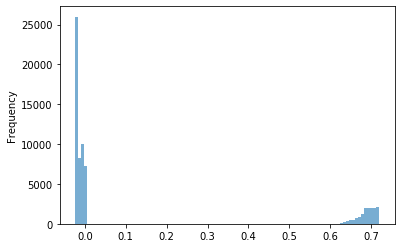

In [38]:
data_df['EigValuesReal_0'].plot.hist(bins=100, alpha=0.6)


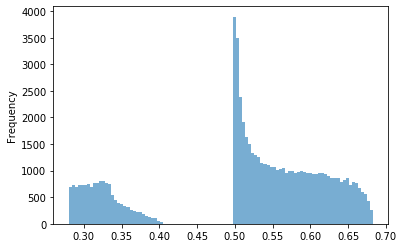

In [39]:
data_df['EigValuesReal_1'].plot.hist(bins=100, alpha=0.6)


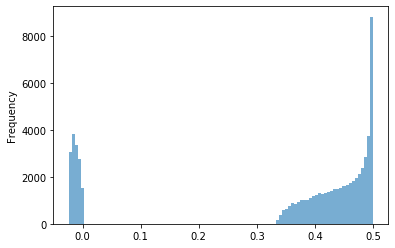

In [40]:
data_df['EigValuesReal_2'].plot.hist(bins=100, alpha=0.6)


In [ ]:
# df_Rapidity_gen = df_gener.query('fMCTrkTrkM > 2.8 & fMCTrkTrkM < 3.3 & fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
df_Rapidity_gen = df_gener.query('fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
generatedevents_Ycut = len(df_Rapidity_gen.index)
generatedevents_Ycut

In [ ]:
InvMass_recon = df_recon['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
# minv_bkgMine = df_backgroundMine['fInvariantMassDimuon'].plot.hist(bins=100, alpha=0.6)


In [ ]:
InvMass_gen = df_gener['fMCTrkTrkM'].plot.hist(bins=100, alpha=0.6)


### Pandas 

Pandas is a library that provides data structures and analysis tools for Pyhton. The two primary data structures of pandas are **Series** (1-dimensional) and **DataFrame** (2-dimensional) and we will work with them.

- **Series** are 1-dimensional ndarray with axis labels.
- **DataFrame** are 2-dimensional tabular data structure with labeled axes (rows and columns).

For more details: https://pandas.pydata.org/pandas-docs/stable/





One of the most interesting tool of DataFrame is the *query()* method (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html). With this method we can query the DataFrame getting elements which **satisfy a boolean expression**.

A "trick" to plot more than one distribution is to create a new dataframe with the data to plot in different columns

In [ ]:
#dataframe with invariant-mass of background and signal
# df_new = pd.concat([df_background['InvMass'], df_signal['InvMass']], axis=1)
# df_new.head()

In [ ]:
# minv_compared = df_new.plot.hist(bins=100, alpha=0.6)

## Data preparation
We need to tell at the model what is signal and what is background.

So we add a 'y' column and label signal and background with **y=1** for signal and **y=0** for background. Then we stack togheter signal and background. This will be the reference for the ML model. 

In [ ]:
plot_VZERO = df_recon['fV0TotalNCells'].plot.hist(bins=100, alpha=0.6)


In [ ]:
plot_fL0inputs = df_recon['fL0inputs'].plot.hist(bins=100, alpha=0.6)


In [ ]:
def return0MSL(x):
    return ((x & (1<<5))>>5)

In [ ]:
def return0MUL(x):
    return ((x & (1<<13))>>13)

In [ ]:
df_recon['f0MSL'] = df_recon.fL0inputs.apply(return0MSL)
plot_0MSL = df_recon['f0MSL'].plot.hist(bins=100, alpha=0.6)


In [ ]:
df_recon['f0MUL'] = df_recon.fL0inputs.apply(return0MUL)
plot_0MUL = df_recon['f0MUL'].plot.hist(bins=100, alpha=0.6)


In [ ]:
len(df_recon.index)

In [ ]:
df_InvMassCutPlusRapidity_for0MUL = df_recon.query('fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
plot_0MUL_rightrapidity = df_InvMassCutPlusRapidity_for0MUL['f0MUL'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusRapidity_for0MUL.index)

In [ ]:
df_InvMassCutPlusRapidity = df_recon.query('fTrkTrkM > 2.8 & fTrkTrkM < 3.3 & fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
df_InvMassCutPlusTriggerConditionPlusRapidity = df_InvMassCutPlusRapidity.query('f0MUL > 0.5')
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
reconstructedevents = len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)
reconstructedevents
# len(df_InvMassCutPlusRapidity.index)

In [ ]:
InvMass_recAfterCuts = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)

In [ ]:
AxE = reconstructedevents/generatedevents_Ycut
AxE

### Template for Pt distr

In [ ]:
bins = np.arange(0,5, 0.10)

In [ ]:
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].hist(bins=bins)

In [ ]:
PtDistr = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].to_numpy()

In [ ]:
counts, edges, plot = plt.hist(PtDistr, bins=bins)

In [ ]:
counts

Now we can fit the distribution and extract the signal

In [ ]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=[2.96, 3.05])
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(2.96, 3.05, 0.00001)
    r_red = np.arange(2.98, 3.005, 0.0001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 2.99, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r_red, gaus_function(r_red, N=popt[2], mu=popt[3], sigma=popt[4]), label='gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+gauss', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, 2.98, 3.005, args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, 2.98, 3.005, args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.title(f'significance: {significance:.1f}')
    plt.legend()
    plt.xlabel('$M_{^{3}He+\pi}$ $(\mathrm{GeV/}c^2)$')
    plt.ylabel('counts / 2.25 $\mathrm{MeV/}c^2$')
    plt.show()

In [ ]:
fit_invmass(inv_sel_simple)

### Optimized model
We can optimize the hyper-parameters to have a **more complex model**

## Final Excercise

Using the query function of pandas perform the "standard" selections

In [ ]:
df_lin_sel = df_data.query('V0CosPA > 0.995')
inv_mass_lin_sel = df_lin_sel['InvMass']

In [ ]:
fit_invmass(inv_mass_lin_sel)

In [ ]:
import ROOT